# Annotation Analysis and Consensus

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from itertools import chain
import scipy as sc
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'

# ML Imports
from sklearn.metrics import cohen_kappa_score


# OS imports
from os.path import join as ospj
from os.path import exists as ospe
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import os

In [2]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [3]:
# Loading seizure level metadata
sz_annots = pd.read_pickle(ospj(prodatapath,'optimized_predicted_channels.pkl'))
sz_annots.head()

,Patient,iEEG_ID,model,stim,approximate_onset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels
0,HUP224,HUP224_phaseII,NRG,1.0,71156.5900,0.75,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
1,HUP224,HUP224_phaseII,NRG,0.0,202170.6800,0.75,[RA09],"[RA09, RA10]","[RA01, RA02, RA03, RA04, RA05, RA09, RB01, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA09, RA1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[10.5, 12.5, 13.0, 11.5, 12.5, 14.0, 13.0, 12....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
2,HUP224,HUP224_phaseII,NRG,0.0,227267.9600,0.75,"[LX06, LX07, LX10, RA09]","[LX06, LX07, LX08, LX10, LX11, RA09, RA10]","[RA01, RA02, RA03, RA04, RA05, RA09, RB01, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA09, RA1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[9.0, 10.0, 9.0, 9.0, 10.5, 10.5, 10.5, 11.5, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
3,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,0.75,[],[],"[LA01, LA03, LA04, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[3.5, 4.0, 3.5, 3.5, 4.5, 5.0, 5.5, 7.0, 10.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."
4,HUP224,HUP224_phaseII,NRG,0.0,415751.7187,0.75,"[LB07, LB08, LW11, LZ05, RA09, RF05]","[LB07, LB08, LB09, LW11, LW12, LZ05, LZ06, RA0...","[LA01, LA03, LA04, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[6.0, 6.5, 6.0, 6.0, 7.5, 9.0, 10.5, 12.0, 11....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0..."


## Annotator Replication

### Seizure -- channel

MannwhitneyuResult(statistic=587025.5, pvalue=8.655099779076584e-103)
-1.2664970697061342


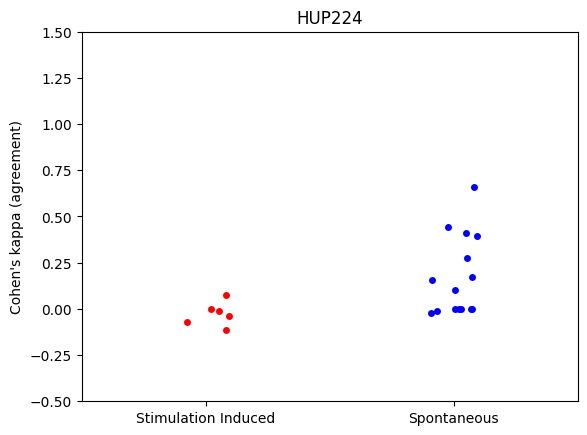

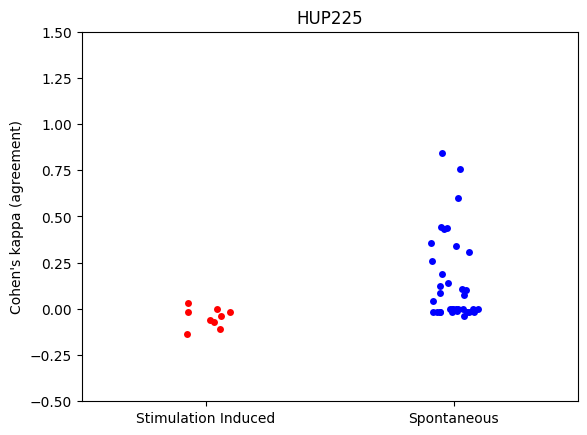

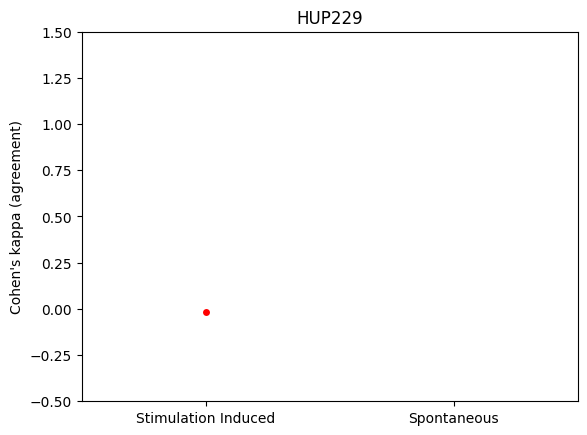

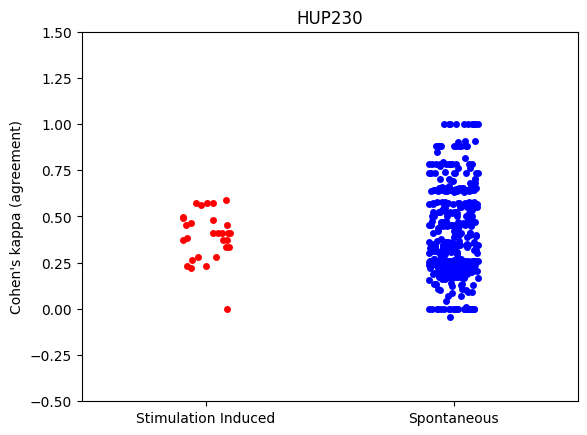

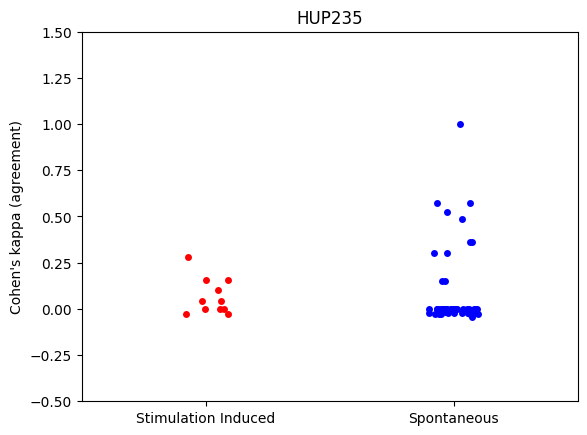

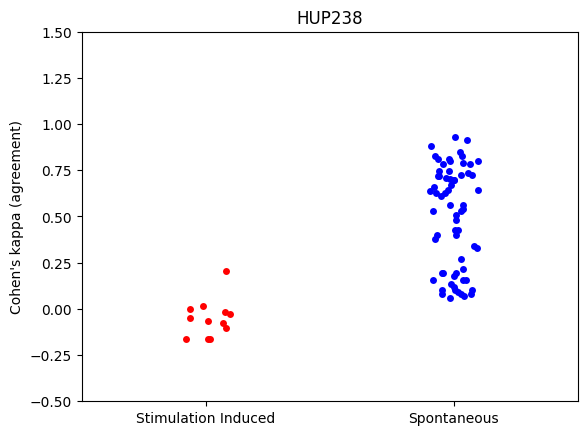

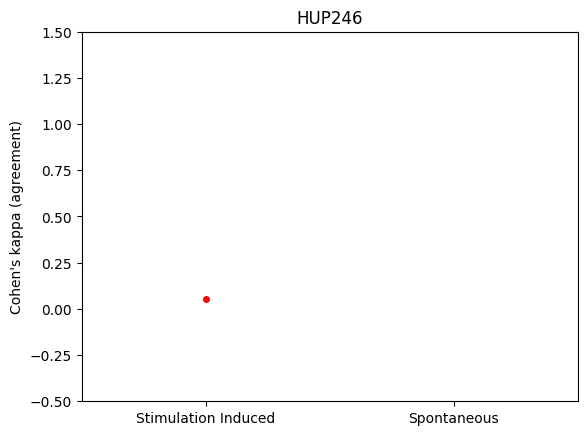

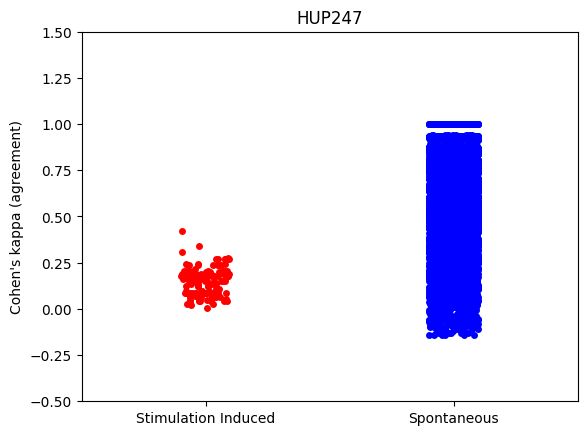

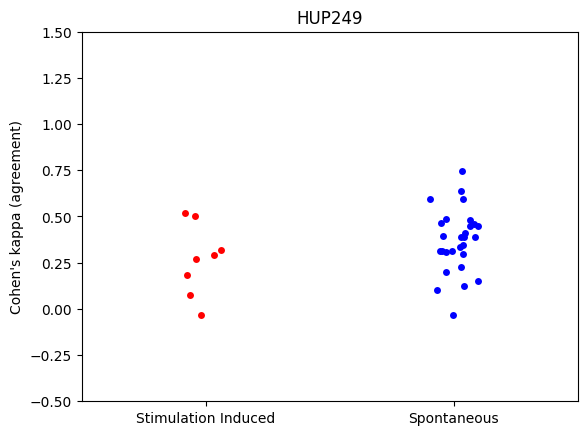

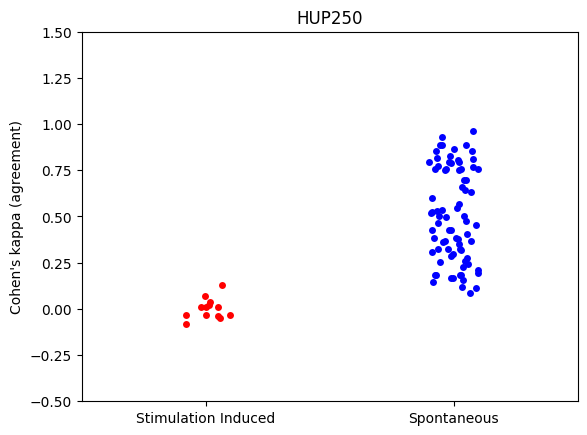

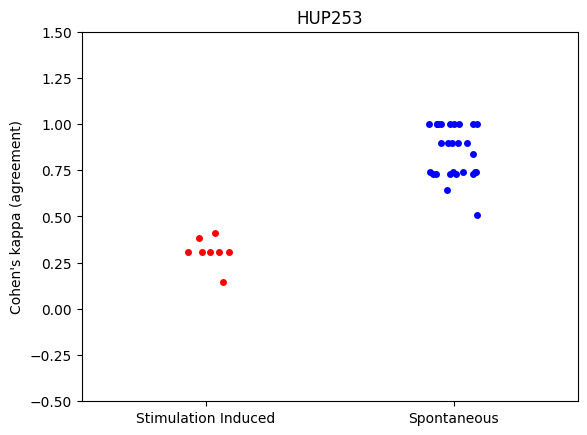

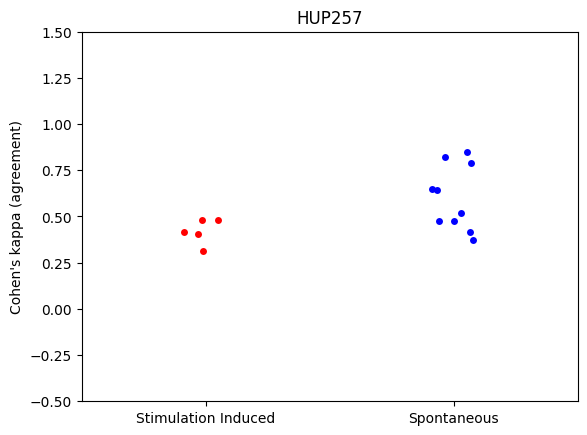

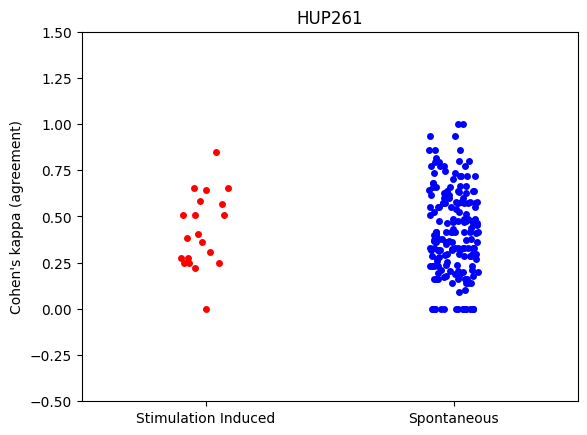

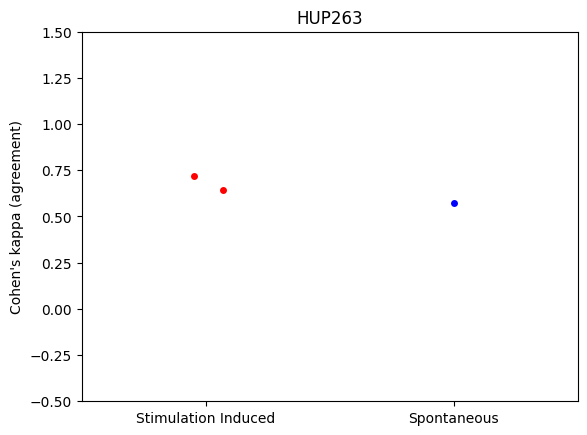

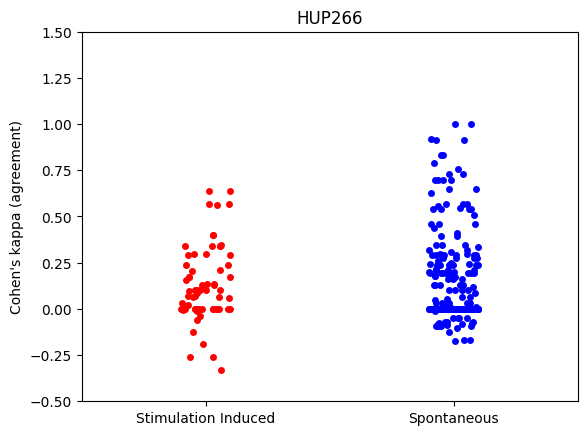

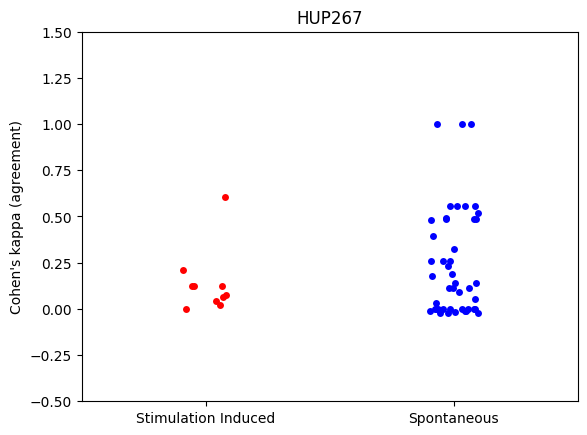

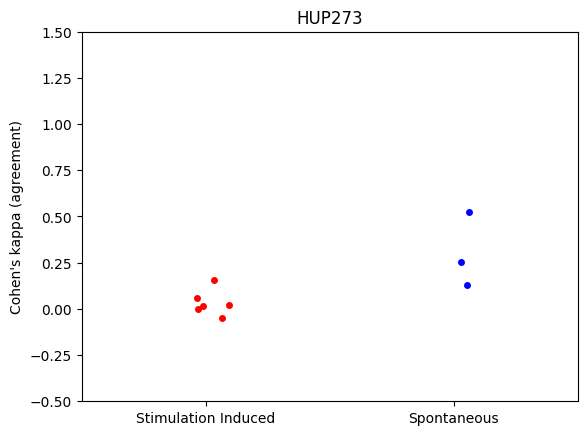

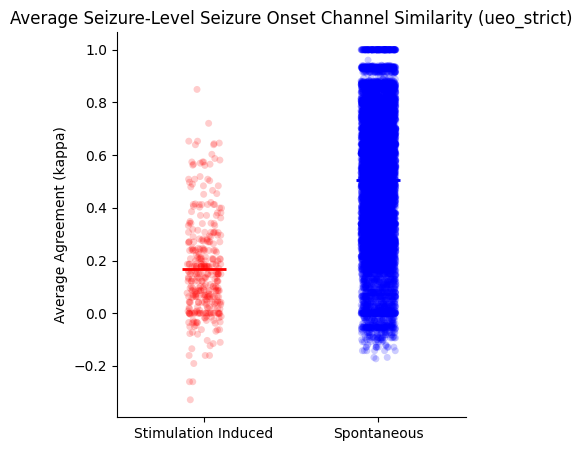

In [4]:
# Can also toggle median or mean within patients
all_stim_annots = []
all_spont_annots = []
avg_stim_annots = []
avg_spont_annots = []
annot_type = 'ueo'
con_type = 'strict'
for pt,group in sz_annots.groupby("Patient"):
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]

    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        chs = group.loc[i,f'{annot_type}_chs_{con_type}']
        ch_mask = np.array([l in chs for l in group.loc[i,'all_channels']])
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            chs2 = group.loc[j,f'{annot_type}_chs_{con_type}']
            ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_channels']])
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
    plt.figure()
    cols=['red','blue']
    for i,dist in enumerate([stim_kappas,spont_kappas]):
        sns.stripplot(x=np.ones(len(dist))*i,y=dist,color=cols[i])
    plt.title(pt)
    plt.ylim([-.5,1.5])
    plt.xlim([-.5,1.5])
    plt.ylabel('Cohen\'s kappa (agreement)')
    plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
    avg_stim_annots.append(np.nanmean(stim_kappas))
    avg_spont_annots.append(np.nanmean(spont_kappas))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)

all_stim_annots = [item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])]
all_spont_annots = [item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])]

all_stim_annots = np.array(all_stim_annots)
all_stim_annots = all_stim_annots[~np.isnan(all_stim_annots)]
all_spont_annots = np.array(all_spont_annots)
all_spont_annots = all_spont_annots[~np.isnan(all_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(all_stim_annots),)),np.ones((len(all_spont_annots),))),axis=0)
all_ys = np.concatenate((all_stim_annots,all_spont_annots))
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",palette=["red","blue"],
              estimator='mean')
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,palette = ['red','blue'],alpha=.2,)

sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Average Agreement (kappa)")
plt.title(f"Average Seizure-Level Seizure Onset Channel Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(all_stim_annots,all_spont_annots))
print(cohens_d(all_stim_annots,all_spont_annots))

### Seizure -- region

In [5]:
pt_groups = sz_annots.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict']:
            chs = row[col]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()
sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)

In [6]:
all_stim_annots = []
all_spont_annots = []
all_stim_patients = []
all_spont_patients = []
avg_stim_annots = []
avg_spont_annots = []
annot_type = 'ueo'
con_type = 'strict'
for pt,group in sz_annots.groupby("Patient"):
    
    if len(group) < 2:
        continue

    spont_dices=[]
    stim_dices=[]
    spont_kappas=[]
    stim_kappas=[]
    for i in range(len(group)):
        group.reset_index(drop=True,inplace=True)
        all_rs = group.loc[i,'all_rs']
        chs = group.loc[i,f'{annot_type}_rs_{con_type}']
        ch_mask = np.array([l in chs for l in group.loc[i,'all_rs']])
        for j in range(i+1,len(group)):
            if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                continue
            chs2 = group.loc[j,f'{annot_type}_rs_{con_type}']
            ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_rs']])
            if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
                stim_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))
            else:
                spont_kappas.append(cohen_kappa_score(ch_mask,ch_mask2))

    avg_stim_annots.append(np.nanmean(stim_kappas))
    avg_spont_annots.append(np.nanmean(spont_kappas))
    all_stim_annots.append(stim_kappas)
    all_spont_annots.append(spont_kappas)
    all_stim_patients.append([pt]*len(stim_kappas))
    all_spont_patients.append([pt]*len(spont_kappas))
    

flat_stim_annots = np.array([item for sublist in all_stim_annots for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_spont_annots = np.array([item for sublist in all_spont_annots for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_stim_patients = np.array([item for sublist in all_stim_patients for item in (sublist if isinstance(sublist, list) else [sublist])])
flat_spont_patients = np.array([item for sublist in all_spont_patients for item in (sublist if isinstance(sublist, list) else [sublist])])

flat_stim_patients = flat_stim_patients[~np.isnan(flat_stim_annots)]
flat_stim_annots = flat_stim_annots[~np.isnan(flat_stim_annots)]
flat_spont_patients = flat_spont_patients[~np.isnan(flat_spont_annots)]
flat_spont_annots = flat_spont_annots[~np.isnan(flat_spont_annots)]


MannwhitneyuResult(statistic=712702.0, pvalue=2.1737996659612048e-85)
-1.0659881834291434


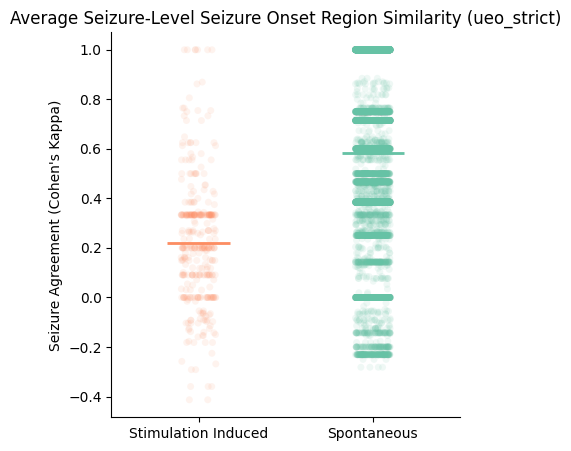

In [7]:
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(flat_stim_annots),)),np.ones((len(flat_spont_annots),))),axis=0)
all_ys = np.concatenate((flat_stim_annots,flat_spont_annots))
all_hues = np.concatenate((flat_stim_patients,flat_spont_patients))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",
              estimator='mean',
              palette = pal[:2][::-1])
plt.setp(ax.collections, sizes=[2000])
sns.stripplot(x=all_xs,y=all_ys,alpha=.1,
            #   hue=all_hues,
              palette = pal[:2][::-1])
#
sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Seizure-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(flat_stim_annots,flat_spont_annots))
print(cohens_d(flat_stim_annots,flat_spont_annots))

### Patient -- region

MannwhitneyuResult(statistic=65.0, pvalue=0.01921722186938686)
-0.8059509913627008


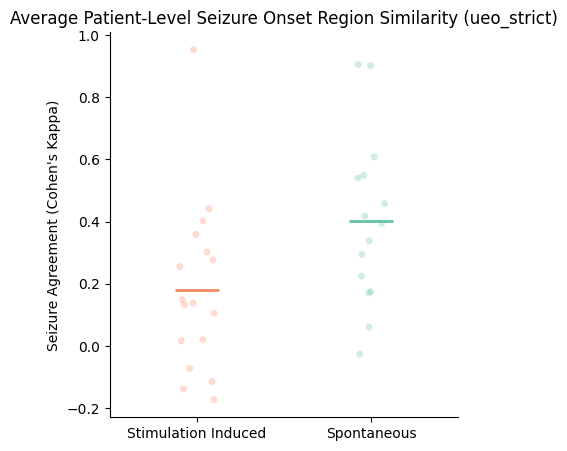

In [8]:
avg_stim_annots = np.array(avg_stim_annots)
avg_stim_annots = avg_stim_annots[~np.isnan(avg_stim_annots)]
avg_spont_annots = np.array(avg_spont_annots)
avg_spont_annots = avg_spont_annots[~np.isnan(avg_spont_annots)]
plt.figure(figsize=(4.5,5))
all_xs = np.concatenate((np.zeros((len(avg_stim_annots),)),np.ones((len(avg_spont_annots),))),axis=0)
all_ys = np.concatenate((avg_stim_annots,avg_spont_annots))
pal = sns.color_palette('Set2')
ax = sns.pointplot(x=all_xs,y=all_ys,errorbar=None,
              markers="_",linestyles="none",
              estimator='mean',
              palette = pal[:2][::-1])
plt.setp(ax.collections, sizes=[1000])
sns.stripplot(x=all_xs,y=all_ys,alpha=.3,palette = pal[:2][::-1])
sns.despine()
plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
plt.ylabel("Seizure Agreement (Cohen's Kappa)")
plt.title(f"Average Patient-Level Seizure Onset Region Similarity ({annot_type}_{con_type})")
print(sc.stats.mannwhitneyu(avg_stim_annots,avg_spont_annots))
print(cohens_d(avg_stim_annots,avg_spont_annots))

## Seizure spread timing

Goal is to create a lineplot with error bar that has the percent of the stim seizure onset zone channels recruited on the y axis and the time since onset on the x axis.
For each stim seizure I need to create that signal. Really i'll have a signal for each stim-spont pair
If I have the time varying % seizing signal for each stim-spont pair I can calculate average across time for a stim seizure
Need to change each 
For each stim seizure:
    extract stim seizure onset zones
    For each spontaneous seizure in the same patient:
        Save time when each of the stim seizure onset regions started seizing in spontaneous seizure

pt_groups = sz_annots.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict']:
            chs = row[col]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()
sz_annots.dropna(axis=0,subset='ueo_rs_strict',inplace=True)
sz_annots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)

In [9]:
sz_annots.head()

,Patient,iEEG_ID,model,stim,approximate_onset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels,ueo_rs_strict,all_rs
0,HUP224,HUP224_phaseII,NRG,1.0,71156.5900,0.75,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem..."
1,HUP224,HUP224_phaseII,NRG,0.0,202170.6800,0.75,[RA09],"[RA09, RA10]","[RA01, RA02, RA03, RA04, RA05, RA09, RB01, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA09, RA1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[10.5, 12.5, 13.0, 11.5, 12.5, 14.0, 13.0, 12....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",right middle temporal,"[EmptyLabel, left amygdala , left middle tem..."
2,HUP224,HUP224_phaseII,NRG,0.0,227267.9600,0.75,"[LX06, LX07, LX10, RA09]","[LX06, LX07, LX08, LX10, LX11, RA09, RA10]","[RA01, RA02, RA03, RA04, RA05, RA09, RB01, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA09, RA1...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[9.0, 10.0, 9.0, 9.0, 10.5, 10.5, 10.5, 11.5, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left postcentral , right middle temporal ]","[EmptyLabel, left amygdala , left middle tem..."
3,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,0.75,[],[],"[LA01, LA03, LA04, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[3.5, 4.0, 3.5, 3.5, 4.5, 5.0, 5.5, 7.0, 10.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",[],"[EmptyLabel, left amygdala , left middle tem..."
4,HUP224,HUP224_phaseII,NRG,0.0,415751.7187,0.75,"[LB07, LB08, LW11, LZ05, RA09, RF05]","[LB07, LB08, LB09, LW11, LW12, LZ05, LZ06, RA0...","[LA01, LA03, LA04, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[6.0, 6.5, 6.0, 6.0, 7.5, 9.0, 10.5, 12.0, 11....","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[ left inferior parietal , right middle tempo...","[EmptyLabel, left amygdala , left middle tem..."


In [10]:
# Converting the sz_chs into sz_rs
def ch2r(row,electrode_regions):
    sz_chs = row.sz_chs
    sz_times = row.sz_times
    electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(sz_chs)]['label']])
    sz_locs = []
    sz_loc_times = []
    for loc in np.unique(electrode_locals):
        loc_inds = loc == electrode_locals
        loc_times = sz_times[loc_inds]
        sz_loc_times.append(min(loc_times))
        sz_locs.append(loc)
    row.sz_locs = np.array(sz_locs)
    row.sz_loc_times = np.array(sz_loc_times)
    return row
    
        
sz_annots[["sz_locs","sz_loc_times"]] = pd.NA
for pt,group in sz_annots.groupby("Patient"):
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    electrode_regions = pd.read_pickle(region_path)
    group = group.apply(lambda x: ch2r(x,electrode_regions),axis=1)
    sz_annots.loc[group.index,["sz_locs","sz_loc_times"]] = group.loc[:,["sz_locs","sz_loc_times"]]

In [11]:
time_points =  np.arange(0,30.5,.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,30.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]

    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns


In [12]:
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots.groupby("Patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        print(pt)
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.sec_rs_loose # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            all_pts.append(pt)
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if np.sum(loc_idx) > 0:
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        all_fraction_ts.append(fraction_ts)
    


HUP224


AttributeError: 'Series' object has no attribute 'sec_rs_loose'

In [ ]:
spont_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points)
spont_spread_df['Patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['Patient'], var_name='Time', value_name='Fraction')


In [ ]:
spont_spread_df_long.head(20)

,Patient,Time,Fraction
0,HUP224,0.0,0.000000
1,HUP224,0.0,0.000000
2,HUP224,0.0,0.000000
3,HUP224,0.0,0.000000
4,HUP224,0.0,0.000000
5,HUP224,0.0,0.000000
6,HUP225,0.0,0.166667
7,HUP225,0.0,0.166667
8,HUP225,0.0,0.166667
9,HUP225,0.0,0.000000


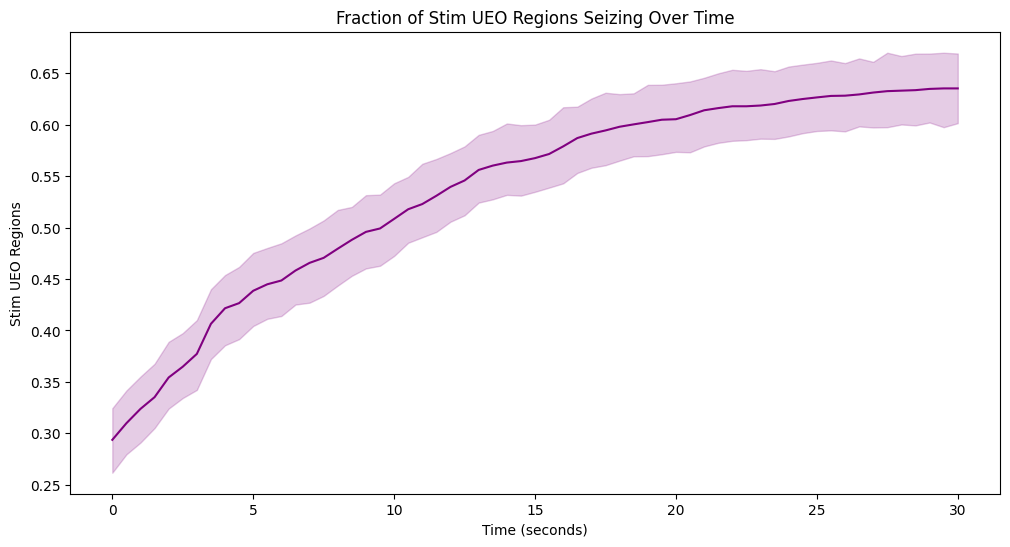

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='purple')
plt.title('Fraction of Stim UEO Regions Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim UEO Regions')
plt.show()
sns.despine()

In [ ]:
# I'll have a matrix where each row is sz and each column is st ch
# I'll need to create a time vector for each of these and calculate what percent of the stim regions are seizing by each time point